In [2]:
import time

import numpy as np
import torch
import torch.utils
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

# And some helpers for visualization.

%matplotlib inline

import matplotlib.pyplot as plt

/home/local/ASURITE/nnjungle/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


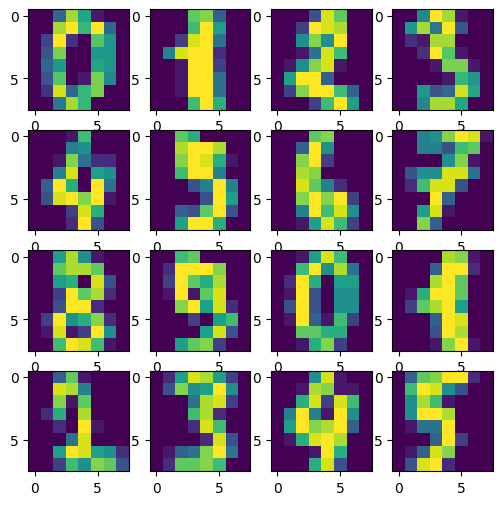

(1347, 1, 8, 8)


In [3]:
X, y = load_digits(return_X_y=True)

# The sklearn Digits data-set, though it contains digit images, keeps these images in vectors
# so we need to reshape them to 2D first. The images are 8x8 px in size and monochrome
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

print(x_train.shape)

In [4]:
class TinyCNN(nn.Module):
    """A very small CNN to classify the sklearn digits data-set."""

    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        # This network has a total complexity of 1216 MAC
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, 2, stride=1, padding=0)
        self.fc1 = nn.Linear(32, n_classes)

    def forward(self, x):
        """Run inference on the tiny CNN, apply the decision layer on the reshaped conv output."""
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

In [5]:
net = TinyCNN(10)

Training: 100%|██████████| 2/2 [00:00<00:00, 21.82it/s]


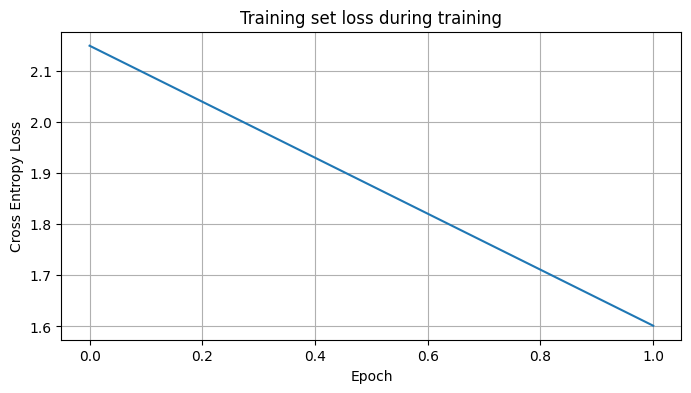

In [6]:
torch.manual_seed(42)

def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)

# Create the tiny CNN with 10 output classes
N_EPOCHS = 2

# Create a train data loader
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

print(train_dataloader)

# Create a test data loader to supply batches for network evaluation (test)
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

# Train the network with Adam, output the test set accuracy every epoch
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_dataloader))

fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

In [7]:
# Test the Torch Network with fp32
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy for fp32 weights and activations: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


test_torch(net, test_dataloader)

Test accuracy for fp32 weights and activations: 71.78%


In [8]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

In [9]:
print(net)
print(x_train)

[[[[ 0.  0.  2. ... 16. 11.  0.]
   [ 0.  0.  8. ...  3.  0.  0.]
   [ 0.  0. 13. ...  0.  0.  0.]
   ...
   [ 0.  6. 16. ... 16.  5.  0.]
   [ 0.  0.  3. ...  8.  0.  0.]
   [ 0.  0.  4. ...  0.  0.  0.]]]


 [[[ 0.  5. 16. ...  0.  0.  0.]
   [ 0. 11. 14. ...  0.  0.  0.]
   [ 0.  8. 11. ...  0.  0.  0.]
   ...
   [ 0.  0.  0. ...  5.  1.  0.]
   [ 0.  1. 11. ... 16. 10.  0.]
   [ 0.  5. 16. ...  6.  1.  0.]]]


 [[[ 0.  0.  4. ...  0.  0.  0.]
   [ 0.  0. 13. ...  7.  0.  0.]
   [ 0.  3. 16. ... 15.  6.  0.]
   ...
   [ 0.  4. 12. ... 11.  6.  0.]
   [ 0.  0. 14. ... 14.  1.  0.]
   [ 0.  0.  7. ...  2.  0.  0.]]]


 ...


 [[[ 0.  0.  9. ... 13.  1.  0.]
   [ 0.  0. 12. ... 16.  7.  0.]
   [ 0.  0.  0. ... 16.  4.  0.]
   ...
   [ 0.  0.  7. ...  0.  0.  0.]
   [ 0.  2. 15. ...  7.  0.  0.]
   [ 0.  0.  9. ... 16.  2.  0.]]]


 [[[ 0.  0.  1. ... 10.  0.  0.]
   [ 0.  0.  8. ... 14.  0.  0.]
   [ 0.  1. 15. ... 15.  0.  0.]
   ...
   [ 0.  0.  4. ...  9.  1.  0.]
   [ 0.  0.  0. ..

In [ ]:
n_bits = 6
print(x_train)
q_module = compile_torch_model(net, x_train, rounding_threshold_bits=6, p_error=0.1)

start_time = time.time()
accs = test_with_concrete(
    q_module,
    test_dataloader,
    use_sim=True,
)
sim_time = time.time() - start_time

print(f"Simulated FHE execution for {n_bits} bit network accuracy: {accs:.2f}%")

In [16]:
# Generate keys first
t = time.time()
q_module.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")
     

Keygen time: 5.81s


In [17]:
# Run inference in FHE on a single encrypted example
mini_test_dataset = TensorDataset(torch.Tensor(x_test[:100, :]), torch.Tensor(y_test[:100]))
mini_test_dataloader = DataLoader(mini_test_dataset)

t = time.time()
accuracy_test = test_with_concrete(
    q_module,
    mini_test_dataloader,
    use_sim=False,
)
elapsed_time = time.time() - t
time_per_inference = elapsed_time / len(mini_test_dataset)
accuracy_percentage = 100 * accuracy_test

print(
    f"Time per inference in FHE: {time_per_inference:.2f} "
    f"with {accuracy_percentage:.2f}% accuracy"
)

100%|██████████| 100/100 [25:46<00:00, 15.47s/it]

Time per inference in FHE: 15.47 with 96.00% accuracy
